In [1]:
import json
import time
import glob
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as cheb
from scipy.stats import moment
from itertools import permutations, combinations
from ipywidgets import IntProgress
from IPython.display import display as pbdisplay
from IPython.display import clear_output
from scipy.interpolate import lagrange
import shutil
import sys
import os.path
from sklearn.decomposition import PCA
from multiprocessing import Pool

from mpl_toolkits.mplot3d import Axes3D
import random

from pyomo.environ import *
from pyomo.gdp import *

from sklearn.cluster import KMeans

In [2]:
timeout = 10
LAMBDA = 0.01
MU = 100
SIGMA = 40
VARK = 1

def r(task):
    ind = 0
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def p(task):
    ind = 1
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def d(task):
    ind = 2
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def remove(arr, elem):
    return np.delete(arr, np.where(np.in1d(arr, elem)))

class TaskSet:
    
    def __init__(self, a):
        if isinstance(a, int):
            rs = np.random.randint(0, 100, size=(a,))
            ps = np.random.randint(0, 100, size=(a,))
            ds = np.random.randint(0, 100, size=(a,))
            self.array = np.array([rs, ps, ds]).T.astype(float)
        else:
            self.array = np.copy(a)
            
    def __repr__(self):
        return "  r  |  p  |  d  \n" + str(self.array)
    
    def copy(self):
        return TaskSet(self.array)
    
    def __getitem__(self, key):
        return TaskSet(self.array[key])
    
    def __iter__(self):
        return iter(self.array)
    
    def C(self, i, tau=0):
        t = tau
        for task in self.array[:i+1]:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def C_max(self, tau=0):
        t = tau
        for task in self.array:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def L(self, i=None, tau=0):
        if i is None:
            return self.C_max(tau) - d(self[-1])
        return self.C(i, tau) - d(self[i])
    
    def L_max(self, tau=0):
        if len(self) == 0: return float('inf')
        return max([self.L(i, tau) for i, _ in enumerate(self)])
    
    def T(self, i=None, tau=0):
        return max(0, self.L(i, tau))
    
    def T_max(self, tau=0):
        return max(0, self.L_max(tau))
    
    def __len__(self):
        return len(self.array)
    
    def __eq__(self, other):
        return self.array == other
    
    def without(self, indexes):
        return TaskSet(np.delete(self.array, np.array(indexes).astype(float), axis=0))
    
    def find(self, item):
        return np.where((self.array == item).all(axis=1))[0]
    
    def transpose(self):
        return self.array.T
    
    def scale_r(self, alpha):
        self.array[:,0] = self.array[:,0]*alpha
        return self
    
    def scale(self, alpha, key='r'):
        if key == 'r': ind = 0
        elif key == 'p': ind = 1
        else: ind = 2
        self.array[:,ind] = self.array[:,ind]*alpha
        return self
    
def dual(N, tau, B):
    if len(N.without(B)) == 0: return float('inf')
    pi_r = r(np.argsort(N, axis=0).transpose())
    bestL = N[pi_r].L(tau=tau)
    for i_k in pi_r:
        toDrop = B.copy()
        toDrop.append(i_k)
        #print(toDrop)
        s = N.without(toDrop)
        #print(s)
        if len(s) != 0:
            task_l = min(s, key=r)
            i_l = N.find(task_l)[0]
            pi_k = remove(pi_r, [i_l, i_k])
            pi_k = np.insert(pi_k, 0, i_l)
            pi_k = np.append(pi_k, i_k)
            L_k = N[pi_k].L(tau=tau)
            if L_k < bestL:
                bestL = L_k
    additionalL = N[pi_r].L(i=0, tau=tau)
    if additionalL > bestL:
        bestL = additionalL
    return bestL

class Instance:
    
    def __init__(self, N, tau=0, pi=[], B=[]):
        self.N = N.copy()
        self.tau = tau
        self.pi = pi.copy()
        self.B = B.copy()
        self.nu = dual(N, tau, B)
        
    def __getitem__(self, key):
        return TaskSet(self.N.array[key])
        
    def best_job(self):
        s = self.N.without(self.B)
        sn = s[r(s.transpose()) <= self.tau]
        if len(sn) == 0:
            f = min(s, key=r)
            #self.tau = r(f)
            #self.nu = dual(self.N, self.tau, self.B)
        else:
            f = min(sn, key=d)
        return self.N.find(f)[0]
    
    def L(self, i=None):
        return self[self.pi].L(i, self.tau)
    
    def T(self, i=None):
        return self[self.pi].T(i, self.tau)
        
    def L_max(self):
        return self[self.pi].L_max(self.tau)
    
    def T_max(self):
        return self[self.pi].T_max(self.tau)
    
    def __repr__(self):
        return "Instance:\n" + repr(self.N) + "\nnu  = " + str(self.nu) + "\ntau = " + str(self.tau) + "\npi  = " + str(self.pi) + "\nB   = " + str(self.B)
    
    
def main(N, tau=0, verbose=False, modified=False):
    tb = time.time()
    b_counter = 0
    #print("bi")
    instances = [Instance(N, tau)]
    #print("ai")
    if modified: bestPi = list(range(len(N)))
    else: bestPi = []
    while len(instances) > 0:
        ti = time.time()
        if ti - tb > timeout:
            return bestPi, -1
        bestInstanceIndex, bestInstance = min(enumerate(instances), key=lambda x: x[1].nu) # + N[x[1].pi].L_max(tau))
        instances.pop(bestInstanceIndex)
        f = bestInstance.best_job()
        f_data = bestInstance[f]
        N1 = bestInstance.N.without(f)
        tau1 = max(r(f_data), bestInstance.tau) + p(f_data)
        B1 = []
        pi1 = bestInstance.pi.copy()
        pi1.append(N.find(f_data)[0])
        i1 = Instance(N1, tau1, pi1, B1)
        N2 = bestInstance.N
        tau2 = bestInstance.tau
        B2 = bestInstance.B.copy()
        B2.append(N2.find(f_data)[0]) #!
        pi2 = bestInstance.pi
        i2 = Instance(N2, tau2, pi2, B2)
        instances += [i1, i2]
        b_counter += 1
        #print(i1)
        if len(pi1) == len(N):
            #print(N[bestPi].L_max(tau))
            #print(pi1)
            if N[pi1].L_max(tau) < N[bestPi].L_max(tau):
                bestPi = pi1.copy()
                if verbose: print(bestPi, '\tLmax =', N[bestPi].L_max(tau))
        #lb = len(instances)
        instances = [i for i in instances if i.nu < N[bestPi].L_max(tau)]
        #print(lb, len(instances))
    return bestPi, b_counter
        
def bruteforce(N, tau=0):
    best_L = N.L_max(tau)
    best_N = N.copy()
    for perm in permutations(N):
        s = TaskSet(perm)
        L = s.L_max(tau)
        if L < best_L:
            best_L = L
            best_N = s.copy()
    return best_L, best_N

def generate_instances(N_TASKS, N_JOBS, fname='data.pickle'):
    tasks = []
    for i in range(N_TASKS):
        s = TaskSet(N_JOBS)
        tasks.append(s)

    with open(fname, 'wb') as f:
        pickle.dump(tasks, f)
        
def parse_instances(fname='data.pickle'):
    with open(fname, 'rb') as f:
        tasks = pickle.load(f)
    return tasks

def simplex(s, verbose=True):
    JOBS = s.array.copy()

    t = dict()
    for i, j in enumerate(JOBS):
        t[str(i)] = {'r': j[0], 'p': j[1], 'd': j[2]}

    JOBS = t
    if verbose: print(JOBS)


    def opt_schedule(JOBS):

        # create model
        m = ConcreteModel()

        # index set to simplify notation
        m.J = Set(initialize=JOBS.keys())
        m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)

        # upper bounds on how long it would take to process all jobs
        tmax = max([JOBS[j]['r'] for j in m.J]) + sum([JOBS[j]['p'] for j in m.J])

        # decision variables
        m.start      = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))
        m.pastdue    = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))
        m.early      = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))
        #m.x = Var(domain=NonNegativeReals, bounds=(0, tmax))
        # additional decision variables for use in the objecive
        m.makespan   = Var(domain=NonNegativeReals, bounds=(0, tmax))
        m.maxpastdue = Var(domain=NonNegativeReals, bounds=(0, tmax), initialize=tmax)
        m.ispastdue  = Var(m.J, domain=Binary)

        # objective function
        #m.OBJ = Objective(expr = sum([m.pastdue[j] for j in m.J]), sense = minimize)
        m.OBJ = Objective(rule= lambda md: md.maxpastdue, sense = minimize)

        # constraints
        #m.c0 = Constraint(m.x == m.maxpastdue)
        m.c1 = Constraint(m.J, rule=lambda m, j: m.start[j] >= JOBS[j]['r'])
        m.c2 = Constraint(m.J, rule=lambda m, j: 
                m.start[j] + JOBS[j]['p'] + m.early[j] == JOBS[j]['d'] + m.pastdue[j])
        m.c3 = Disjunction(m.PAIRS, rule=lambda m, j, k:
            [m.start[j] + JOBS[j]['p'] <= m.start[k], 
             m.start[k] + JOBS[k]['p'] <= m.start[j]])    

        m.c4 = Constraint(m.J, rule=lambda m, j: m.pastdue[j] <= m.maxpastdue)
        m.c5 = Constraint(m.J, rule=lambda m, j: m.start[j] + JOBS[j]['p'] <= m.makespan)
        m.c6 = Constraint(m.J, rule=lambda m, j: m.pastdue[j] <= tmax*m.ispastdue[j])

        TransformationFactory('gdp.hull').apply_to(m)
        if verbose:
            SolverFactory('glpk').solve(m).write()
        else:
            SolverFactory('glpk').solve(m)

        SCHEDULE = {}
        for j in m.J:
            SCHEDULE[j] = {'machine': 1, 'start': m.start[j](), 'finish': m.start[j]() + JOBS[j]['p']}

        if verbose: print(SCHEDULE)
        return SCHEDULE

    SCHEDULE = opt_schedule(JOBS)
    pi = list(map(int, sorted(SCHEDULE, key=lambda x: SCHEDULE[x]['start'])))
    return pi

def scale_timing(N_POINTS, FACTOR_MAX, N_TASKS, method='dual'):
    """
    Available methods: dual, simplex
    """
    pBar = IntProgress(min=0, max=N_POINTS**2, step=1)
    pbdisplay(pBar)
    results = np.zeros((N_POINTS, N_POINTS))
    for n in range(N_TASKS):
        pBar.value = 0
        times = np.zeros((N_POINTS, N_POINTS))
        s = tasks[n]
        for factor_r in range(N_POINTS):
            for factor_d in range(N_POINTS):
                pBar.value += 1
                scaled_s = s.copy().scale(FACTOR_MAX*factor_r/N_POINTS, key='r').scale(FACTOR_MAX*factor_d/N_POINTS, key='d')
                tb = time.time()
                if method == 'dual':
                    sched, count = main(s)
                elif method == 'simplex':
                    sched = simplex(s, verbose=False)
                times[factor_r, factor_d] = time.time() - tb
        results = results + times
    #results = results / N_TASKS
    return results

def heatmap(z, N_POINTS, FACTOR_MAX, N_TASKS, method='dual'):
    y, x = np.meshgrid(np.linspace(0, FACTOR_MAX, N_POINTS), np.linspace(0, FACTOR_MAX, N_POINTS))
    #print(x.shape, y.shape, z.shape)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    z = z[:-1, :-1]
    z_min, z_max = np.abs(z).min(), np.abs(z).max()

    fig, ax = plt.subplots(figsize=(8,8))

    c = ax.pcolormesh(x, y, z, cmap='Blues', vmin=z_min, vmax=z_max)
    #ax.set_title('pcolormesh')
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    ax.set_xlabel('α')
    ax.set_ylabel('γ')
    ax.set_title("%s tasks and %s*%s points with %s method" % (N_TASKS, N_POINTS, N_POINTS, method))
    fig.colorbar(c, ax=ax)

    plt.show()
    
def plot_heatmap(N_POINTS=15, FACTOR_MAX=1000, N_TASKS=5, method='dual'):
    z = scale_timing(N_POINTS=15, FACTOR_MAX=1000, N_TASKS=5, method='dual')
    heatmap(z, N_POINTS=15, FACTOR_MAX=1000, N_TASKS=5, method='dual')
    fname = "%spoints%smax%stasks%smethod.json" % (N_POINTS, FACTOR_MAX, N_TASKS, method)
    with open(fname, 'w') as f:
        json.dump(z, fname)
        
def lagrange_interpolation(key, s):
    alphaRange = np.arange(0, 2.1, 0.2)
    scaledSchedules = []
    for alpha in alphaRange:
        scaledSchedules.append(s.copy().scale(alpha, key=key))
    flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))

    #print("\rCurrently working with", n)
    approxResults = []
    if len(alphaRange) != len(scaledSchedules): raise RuntimeError()
    for i, a in enumerate(alphaRange):
        if a != 1:
            s = scaledSchedules[i]
            sched, count = main(s, verbose=False)
            if count == -1: continue
            Lmax = s[sched].L_max()
            approxResults.append((a, Lmax))
    approxResults = np.array(approxResults)
    if len(approxResults) == 0:
        return float('inf')
    x = approxResults[:,0]
    y = approxResults[:,1]
    #print(len(x))
    #print(x, y)
    poly = lagrange(x, y)
    return poly(1.)

def chebyshev_interpolation(k, schedule):
    global realResult
    global approxResults
    global m
    global s
    global key
    key = k
    s = schedule

    def test_schedule(alpha_arr):
        global key
        global approxResults
        global m
        global s
        approxResults = []
        for a in alpha_arr:
            #print("\ra =", a, end='')
            scaled_s = s.copy().scale(a, key=key)
            #flattenedScaled_s = list(map(lambda x: x.array.flatten(), scaled_s))
            bestPi, bestCounter = main(scaled_s, verbose=False)
            Lmax = scaled_s[bestPi].L_max()
            approxResults.append((a, Lmax))
        approxResults = np.array(approxResults)
        return approxResults[:,1]

    
    C = cheb.Chebyshev.interpolate(test_schedule, 13, [0, 2])
    return C(1.)


def mul_lagrange_interpolation(s):
    N_POINTS = 10

    delta_r = 0.1
    delta_p = 0.2
    delta_d = 0.05
    N_TASKS = 3

    scaledSchedules = []
    alphaRange = []
    #alphaRange.append(1.)
    ticks = [(1.,1.,1.)]
    for factor in range(N_POINTS):
        factor_r = (5+factor)*delta_r
        factor_p = factor*delta_p
        factor_d = (15+factor)*delta_d
        if factor_r != 1:
            scaledSchedules.append(s.copy().scale(factor_r, key='r')
                                   .scale(factor_p, key='p')
                                   .scale(factor_d, key='d'))
            alphaRange.append(factor_r)
            ticks.append((round(factor_r,2),
                      round(factor_p,2),
                      round(factor_d,2)))
    flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))
    #print(ticks)
    #print("\rCurrently working with", n)
    approxResults = []
    if len(alphaRange) != len(scaledSchedules): raise RuntimeError()
    for i, a in enumerate(alphaRange):
        s = scaledSchedules[i]
        sched, count = main(s, verbose=False)
        if count == -1: continue
        Lmax = s[sched].L_max()
        #print(n, alphaRange[i], sched)
        approxResults.append((a, Lmax))
    approxResults = np.array(approxResults)
    if len(approxResults) == 0:
        return float('inf')
    x = approxResults[:,0]
    y = approxResults[:,1]
    #print(len(x))
    #print(x, y)
    poly = lagrange(x, y)
    return poly(1.)


# Генерируем возможные требования

In [3]:
N_POINTS = 6

points = range(1, N_POINTS + 1)
jobs = []
for ri in points:
    for pi in range(ri, N_POINTS + 1):
        for di in range(ri + pi, N_POINTS + 1):
            jobs.append((ri, pi, di))
            #if ri % 2 == 0:
            #    if di < N_POINTS:
            #        jobs.append((2*ri+1, 2*pi+1, 2*di+1))
            #jobs.append((2*ri, 2*pi, 2*di))

In [4]:
# remove jobs with (1, 1, d)
jobs = jobs[5:]

In [5]:
jobs

[(1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 2, 6),
 (1, 3, 4),
 (1, 3, 5),
 (1, 3, 6),
 (1, 4, 5),
 (1, 4, 6),
 (1, 5, 6),
 (2, 2, 4),
 (2, 2, 5),
 (2, 2, 6),
 (2, 3, 5),
 (2, 3, 6),
 (2, 4, 6),
 (3, 3, 6)]

In [6]:
rs = list(map(lambda x: x[0], jobs))
ps = list(map(lambda x: x[1], jobs))
ds = list(map(lambda x: x[2], jobs))

# Пространство (r, p, d)

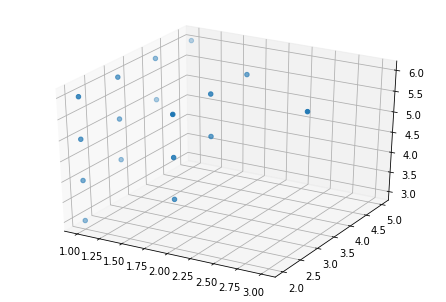

In [7]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rs, ps, ds)

# Комбинации по 6 различных требований

In [8]:
c = combinations(jobs, 2)
a = np.array(list(c))
a.shape

(136, 2, 3)

# Удаляем запаздывающие требования

In [9]:
def check(i):
    return (i[:,0] != i[0,0]).any() and (i[:,2] != i[0,2]).any() and (i[:,1] != i[0,1]).any() 

In [10]:
a = [i for i in a if check(i)]

In [11]:
a = np.array(a)

In [15]:
a.shape

(32, 2, 3)

# Сдвиг по r и d "до упора"

In [16]:
for i, t in enumerate(a):
    r_addition = N_POINTS - max(t[:,0])
    d_addition = N_POINTS - max(t[:,2])
    a[i,:,0] = a[i,:,0] + r_addition
    a[i,:,2] = a[i,:,2] + d_addition

# Удаление дубликатов

In [17]:
b = []
for c, i in enumerate(a.tolist()):
    if i not in b:
        b.append(i)
    print(c, '\r', end='')
b = np.array(b)

In [18]:
b = [i for i in b if check(i)]
b = np.array(b)

# Удаляем каждый второй пример

In [ ]:
b = b[::2]

In [19]:
b.shape

(25, 2, 3)

# Создаём список примеров

In [20]:
tasks = list(map(TaskSet, b))

# Находим решения

In [33]:
df = pd.DataFrame(columns=['Complexity',
                           'L_max',
                           #'r',
                           #'p',
                           #'d',
                           #'Multi',
                           #'r_Cheb',
                           #'p_Cheb',
                           #'d_Cheb',
                           'Orig time',
                           #'r time',
                           #'Multi time',
                           'Schedule',
                           'Instance'])
pBar = IntProgress(min=0, max=len(tasks))
pbdisplay(pBar)
for i, s in enumerate(tasks[:20]):
    tb = time.time()
    pi, count = main(s)
    to = time.time() - tb
    Lmax = s[pi].L_max()
    
    #tb = time.time()
    #r_lagrange = lagrange_interpolation('r', s)
    #tr = time.time() - tb
    
    #p_lagrange = lagrange_interpolation('p', s)
    #d_lagrange = lagrange_interpolation('d', s)
    
    #tb = time.time()
    #m_lagrange = mul_lagrange_interpolation(s)
    #tm = time.time() - tb
    #r_chebyshev = chebyshev_interpolation('r', s)
    #p_chebyshev = chebyshev_interpolation('p', s)
    #d_chebyshev = chebyshev_interpolation('d', s)
    df.loc[i] = [count,
                 Lmax,
                 #r_lagrange,
                 #p_lagrange,
                 #d_lagrange,
                 #m_lagrange,
                 #r_chebyshev,
                 #p_chebyshev,
                 #d_chebyshev,
                 to,
                 #tr,
                 #tm,
                 pi,
                 s.array.flatten().astype(int)]
                 #json.dumps(s.array.astype(int).tolist())]
    pBar.value += 1
df = df.sort_values(by=['Complexity'])
df.to_excel("6.xlsx")

IntProgress(value=0, max=25)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


In [37]:
df.reset_index()

,index,Complexity,L_max,Orig time,Schedule,Instance
0,0,2,4,0.011989,"[0, 1]","[5, 2, 4, 6, 3, 6]"
1,17,2,5,0.003999,"[0, 1]","[5, 4, 5, 6, 2, 6]"
2,16,2,6,0.002000,"[0, 1]","[5, 4, 6, 6, 2, 5]"
3,14,2,6,0.005967,"[0, 1]","[5, 3, 5, 6, 4, 6]"
4,13,2,5,0.005000,"[0, 1]","[5, 3, 6, 6, 2, 5]"
5,12,2,6,0.002985,"[0, 1]","[5, 3, 4, 6, 4, 6]"
6,11,2,4,0.008990,"[0, 1]","[5, 3, 4, 6, 2, 6]"
7,10,2,4,0.008016,"[0, 1]","[5, 3, 5, 6, 2, 6]"
8,18,2,6,0.005003,"[0, 1]","[5, 4, 5, 6, 3, 6]"
9,9,2,5,0.007994,"[0, 1]","[5, 2, 6, 6, 3, 5]"


In [25]:
def test_task_parallel(s):
    print(__name__, end='')
    df = pd.DataFrame(columns=['Complexity',
                           'L_max',
                           #'r',
                           #'p',
                           #'d',
                           #'Multi',
                           #'r_Cheb',
                           #'p_Cheb',
                           #'d_Cheb',
                           'Orig time',
                           #'r time',
                           #'Multi time',
                           'Schedule',
                           'Instance'])
    tb = time.time()
    pi, count = main(s)
    to = time.time() - tb
    Lmax = s[pi].L_max()
    #print("\r", Lmax, end='')
    
    #tb = time.time()
    #r_lagrange = lagrange_interpolation('r', s)
    #tr = time.time() - tb
    
    #p_lagrange = lagrange_interpolation('p', s)
    #d_lagrange = lagrange_interpolation('d', s)
    
    #tb = time.time()
    #m_lagrange = mul_lagrange_interpolation(s)
    #tm = time.time() - tb
    #r_chebyshev = chebyshev_interpolation('r', s)
    #p_chebyshev = chebyshev_interpolation('p', s)
    #d_chebyshev = chebyshev_interpolation('d', s)
    df.loc[0] = [count,
                 Lmax,
                 #r_lagrange,
                 #p_lagrange,
                 #d_lagrange,
                 #m_lagrange,
                 #r_chebyshev,
                 #p_chebyshev,
                 #d_chebyshev,
                 to,
                 #tr,
                 #tm,
                 pi,
                 s.array.flatten().astype(int)]
                 #json.dumps(s.array.astype(int).tolist())]
    return df

In [ ]:
if __name__ == '__main__':
    with Pool(4) as pool:
        results = pool.map(testtaskparallel, tasks[:4])

In [31]:
pd.concat(list(map(test_task_parallel, tasks[:4])))

 3

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


,Complexity,L_max,Orig time,Schedule,Instance
0,2,4,0.006001,"[0, 1]","[5, 2, 4, 6, 3, 6]"
0,2,4,0.006998,"[0, 1]","[5, 2, 3, 6, 3, 6]"
0,2,5,0.004001,"[0, 1]","[5, 2, 3, 6, 4, 6]"
0,2,3,0.003998,"[0, 1]","[4, 2, 3, 6, 3, 6]"


# Загружаем датасет

In [60]:
df = pd.read_excel("6.xlsx")

# Ужимаем размерность

In [70]:
pca = PCA(n_components=2)
coords = []
for i in df.Instance.values:
    coords.append(json.loads(i.replace(" ", ', ')))
coords_pca = pca.fit_transform(coords)

In [71]:
pca = PCA(n_components=3)
coords = []
for i in df.Instance.values:
    coords.append(json.loads(i.replace(" ", ', ')))
coords_pca3 = pca.fit_transform(coords)

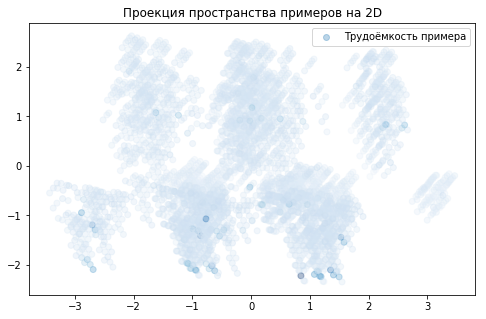

In [80]:
fig = plt.figure(figsize=(8,5))
plt.scatter(coords_pca[:,0], coords_pca[:,1], c=df['Orig time'].values, alpha=0.3, cmap='Blues', label='Трудоёмкость примера')
plt.title("Проекция пространства примеров на 2D")
plt.legend()

Text(0.5, 0.92, 'Проекция пространства примеров на 2D')

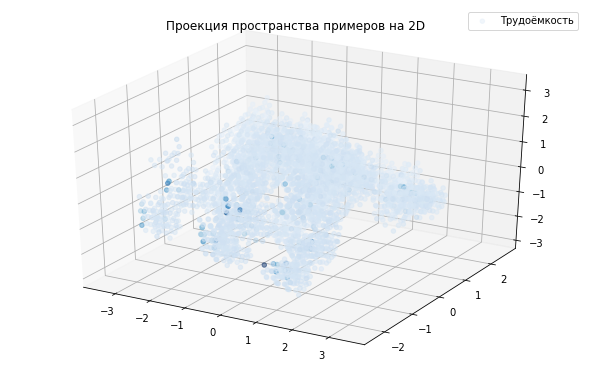

In [83]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca3[:,0], coords_pca3[:,1], coords_pca3[:,2], c=df['Complexity'].values, depthshade=False, alpha=0.5, cmap='Blues', label='Трудоёмкость')
ax.legend()
ax.set_title("Проекция пространства примеров на 2D")

# Кластеризация (с учётом трудоёмкости)

In [84]:
cluster_coords = []
for i in zip(coords, df['Complexity'].values):
    t = [j for j in i[0]]
    t.append(i[1])
    cluster_coords.append(t)

In [85]:
kmeans2 = KMeans(n_clusters=2).fit_predict(cluster_coords)
kmeans4 = KMeans(n_clusters=4).fit_predict(cluster_coords)
kmeans8 = KMeans(n_clusters=8).fit_predict(cluster_coords)

In [86]:
pca = PCA(n_components=3)
coords_pca = pca.fit_transform(cluster_coords)

Text(0.5, 0.92, 'Результаты кластеризации с учётом трудоёмкости')

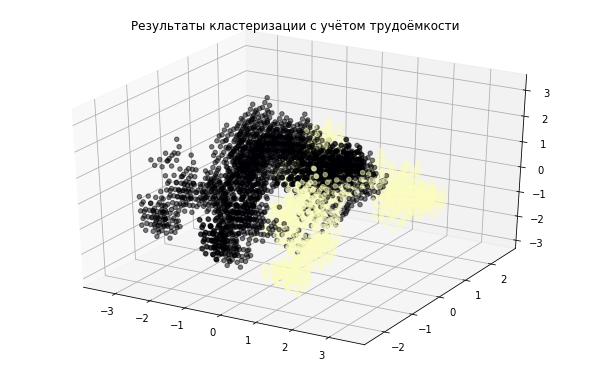

In [91]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca[:,0], coords_pca[:,1], coords_pca[:,2], c=kmeans2, depthshade=False, alpha=0.5, cmap='magma')
ax.set_title("Результаты кластеризации с учётом трудоёмкости")

Text(0.5, 0.92, 'Результаты кластеризации с учётом трудоёмкости')

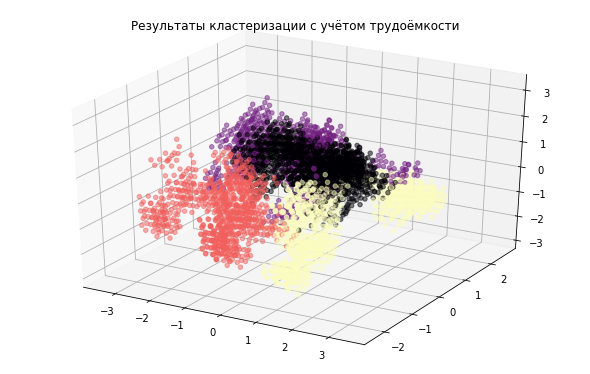

In [92]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca[:,0], coords_pca[:,1], coords_pca[:,2], c=kmeans4, depthshade=False, alpha=0.5, cmap='magma')
ax.set_title("Результаты кластеризации с учётом трудоёмкости")

Text(0.5, 0.92, 'Результаты кластеризации с учётом трудоёмкости')

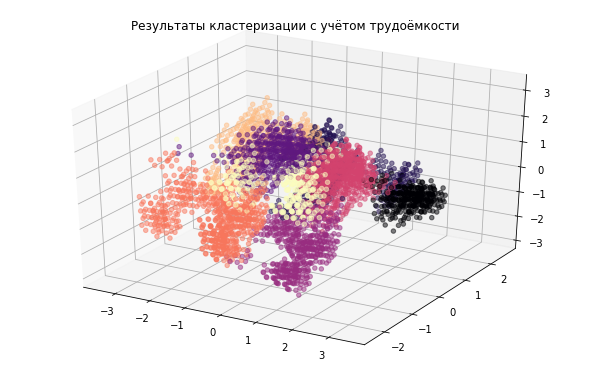

In [93]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca[:,0], coords_pca[:,1], coords_pca[:,2], c=kmeans8, depthshade=False, alpha=0.5, cmap='magma')
ax.set_title("Результаты кластеризации с учётом трудоёмкости")

# Кластеризация без учёта трудоёмкости

In [95]:
kmeans2 = KMeans(n_clusters=2).fit_predict(coords)
kmeans4 = KMeans(n_clusters=4).fit_predict(coords)
kmeans8 = KMeans(n_clusters=8).fit_predict(coords)

In [96]:
pca = PCA(n_components=3)
coords_pca = pca.fit_transform(coords)

Text(0.5, 0.92, 'Результаты кластеризации без учёта трудоёмкости')

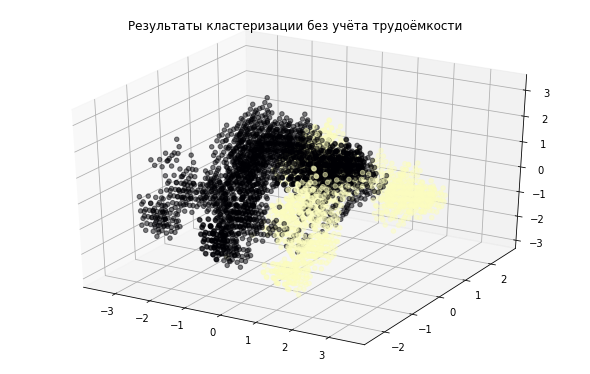

In [97]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca[:,0], coords_pca[:,1], coords_pca[:,2], c=kmeans2, depthshade=False, alpha=0.5, cmap='magma')
ax.set_title("Результаты кластеризации без учёта трудоёмкости")

Text(0.5, 0.92, 'Результаты кластеризации без учёта трудоёмкости')

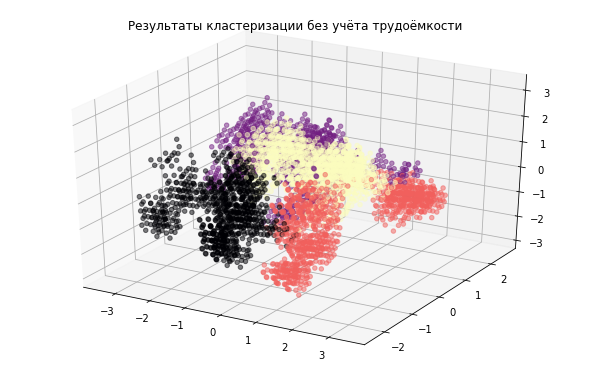

In [98]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca[:,0], coords_pca[:,1], coords_pca[:,2], c=kmeans4, depthshade=False, alpha=0.5, cmap='magma')
ax.set_title("Результаты кластеризации без учёта трудоёмкости")

Text(0.5, 0.92, 'Результаты кластеризации без учёта трудоёмкости')

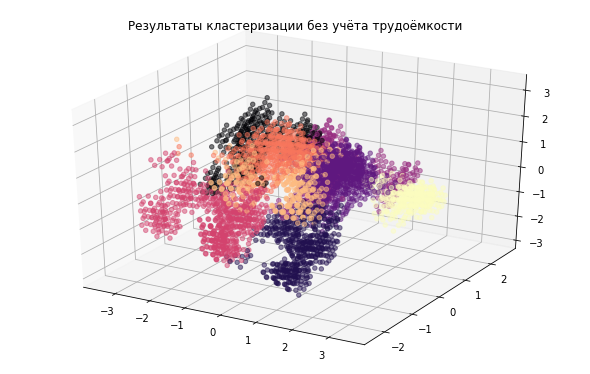

In [99]:
fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(coords_pca[:,0], coords_pca[:,1], coords_pca[:,2], c=kmeans8, depthshade=False, alpha=0.5, cmap='magma')
ax.set_title("Результаты кластеризации без учёта трудоёмкости")

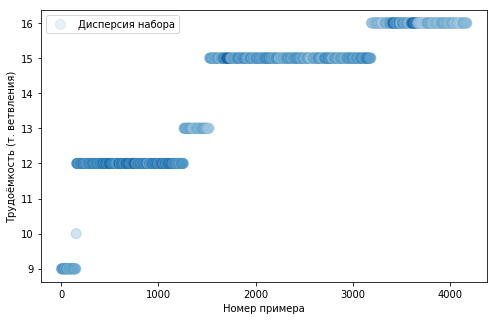

In [144]:
fig = plt.figure(figsize=(8,5))
colors = [np.var(json.loads(i.replace(" ", ', '))) for i in df.Instance.values]
plt.scatter(np.arange(len(df.Complexity)), df.Complexity.values, s=100, c=colors, cmap='Blues', alpha=0.1, label="Дисперсия набора")
plt.xlabel("Номер примера")
plt.ylabel("Трудоёмкость (т. ветвления)")
#plt.title("")
plt.legend()
#plt.grid()